In [29]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

sys.path.extend(['/data/GitHub/NeuroPy'])  # Add path to NeuroPy repository here

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.io.minianio import MinianIO
from neuropy.io.dlcio import DLC
from neuropy.core.session import ProcessData
import neuropy.io.openephysio as oeio


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dir_use = "/data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin"
sess = ProcessData(dir_use)
print(sess.recinfo)

filename: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Finn2_psilocybin_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



# Import miniscope data and timestamps

First, run the session through the minian pipeline and save your S, A, and C variables to numpy arrays in a "minian" folder somewhere in the session folder

Second, designate any *corrupted files* by creating a "corrupted_videos.csv" file in the folder where your timeStamps.csv file lives. List the index to each corrupted file separated by commas. Even if you have concatenated all your videos from different recordings together in minian this file you should still put this in the file for each recording with a corrupted file.

In [12]:
# Now, load in all the video timestamps and minian data.
sess.miniscope = MiniscopeIO(sess.basepath)
sess.miniscope.load_all_timestamps()
sess.minian = MinianIO(sess.basepath / "Miniscope_combined" / "minian")

Keeping 102335 good frames found in "good_frames_bool.npy" file


In [17]:
# Show rough timestamps for all
sess.minian.times

,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
4,4,207,0,2023-05-25 11:30:40.952
5,5,274,0,2023-05-25 11:30:41.019
6,6,341,0,2023-05-25 11:30:41.086
7,7,408,0,2023-05-25 11:30:41.153
8,8,476,0,2023-05-25 11:30:41.221
...,...,...,...,...
16,16,1039,0,2023-05-25 15:49:31.546
17,17,1106,0,2023-05-25 15:49:31.613
18,18,1173,0,2023-05-25 15:49:31.680
19,19,1240,0,2023-05-25 15:49:31.747


# Create sync_df DataFrame for all ephys recordings

In [19]:
sess.sync = oeio.create_sync_df(sess.basepath, sr_dat=sess.datfile.sampling_rate, sr_eeg=sess.eegfile.sampling_rate)
sess.sync

start time = 2023-05-25 11:29:42.819033-04:00
start time = 2023-05-25 12:07:50.764904-04:00
start time = 2023-05-25 13:10:53.348552-04:00
start time = 2023-05-25 14:01:56.921020-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2023-05-25 11:29:42.819033-04:00,start,0,0.000000,0,0.0000
1,0,2023-05-25 11:58:16.901133-04:00,stop,51422463,1714.082100,2142602,1714.0816
2,1,2023-05-25 12:07:50.764904-04:00,start,51422464,1714.082133,2142603,1714.0824
3,1,2023-05-25 13:08:37.595804-04:00,stop,160827391,5360.913033,6701141,5360.9128
4,2,2023-05-25 13:10:53.348552-04:00,start,160827392,5360.913067,6701142,5360.9136
5,2,2023-05-25 14:00:12.102652-04:00,stop,249590015,8319.667167,10399583,8319.6664
6,3,2023-05-25 14:01:56.921020-04:00,start,249590016,8319.667200,10399584,8319.6672
7,3,2023-05-25 15:51:50.363120-04:00,stop,447393279,14913.109300,18641386,14913.1088


# Get TTLs to OE for synchronization

In [58]:
from datetime import datetime
import os
tak1_file = "/run/media/nkinsky/Nat1/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.11.17 PM.tak"
tak2_file = "/run/media/nkinsky/Nat1/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.46.32 PM.tak"
(pd.Timestamp(datetime.fromtimestamp(os.path.getmtime(tak1_file))))

Timestamp('2023-05-25 13:46:28.948677')

In [ ]:
# NRK note - check in code if timestamps between OE and optitrack match up well, otherwise chuck them and go by timestamps!

In [21]:
sess.ttl_df.channel_states.unique()

array([-1,  1], dtype=int16)

In [20]:
sess.ttl_df = oeio.load_all_ttl_events(sess.basepath)
sess.ttl_df

,channel_states,timestamps,datetimes,sample_number,event_name
0,-1,1741564,2023-05-25 11:30:40.871166333-04:00,1741564,
1,1,1743516,2023-05-25 11:30:40.936233-04:00,1743516,
2,-1,1745537,2023-05-25 11:30:41.003599667-04:00,1745537,
3,1,1747591,2023-05-25 11:30:41.072066333-04:00,1747591,
4,-1,1749580,2023-05-25 11:30:41.138366333-04:00,1749580,
...,...,...,...,...,...
41394,-1,193645537,2023-05-25 15:49:31.772253333-04:00,443235553,
41395,1,193647591,2023-05-25 15:49:31.840720-04:00,443237607,
41396,-1,193649613,2023-05-25 15:49:31.908120-04:00,443239629,
41397,1,193651606,2023-05-25 15:49:31.974553333-04:00,443241622,


# Import DLC files

### Need to use combination of .tak creation time and nframes to get actual start time in microseconds for Finn2. Will vary for each animal!
Below has only second precision.

In [172]:
sess.dlc = DLC(sess.basepath)

Using tracking file #1: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.11.17 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #2: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 01.46.32 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #3: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 02.02.15 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #4: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 02.30.20 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #5: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 2023-05-25 03.03.27 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.h5
Using tracking file #6: /data3/Psilocybin/Recording_Rats/Finn2/2023_05_25_psilocybin/Take 

In [173]:
sess.dlc.get_timestamps()

No Optitrack csv file found at Take 2023-05-25 01.11.17 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 13:11:17
No Optitrack csv file found at Take 2023-05-25 01.46.32 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 13:46:32
No Optitrack csv file found at Take 2023-05-25 02.02.15 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 14:02:15
No Optitrack csv file found at Take 2023-05-25 02.30.20 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferring start time from file name. SECOND PRECISION IN START TIME!!!
2023-05-25 14:30:20
No Optitrack csv file found at Take 2023-05-25 03.03.27 PM-Camera 4 (#410110)DLC_resnet50_Psilocybin_DLCFeb13shuffle1_500000.
Inferr

<Axes: title={'center': 'Finn2: crown_middle'}, xlabel='lcutoff = 0.9'>

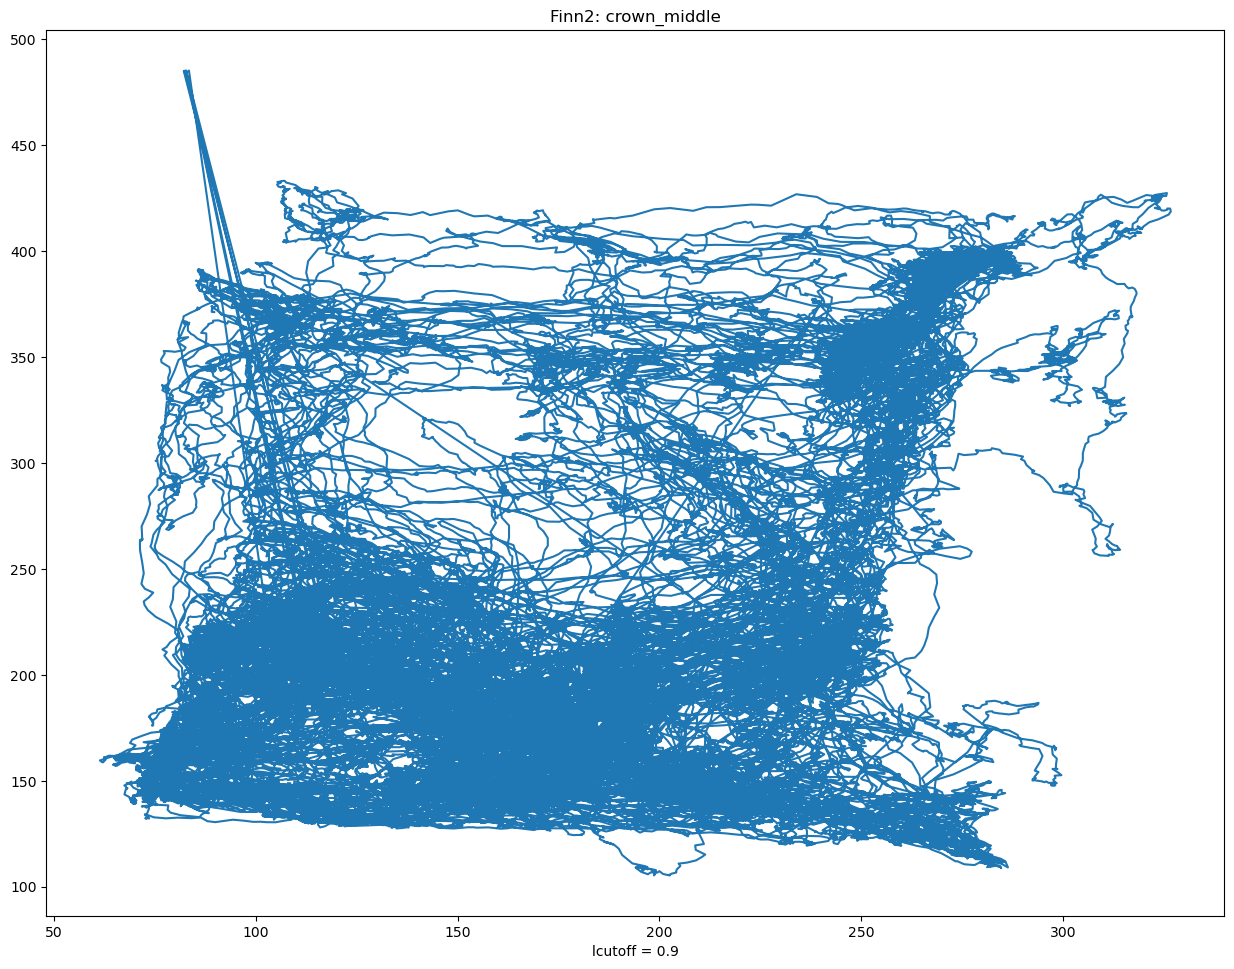

In [174]:
# Plot animal crown position for all points with confidence of 0.9 or more
sess.dlc.plot2d(bodyparts="crown_middle", lcutoff=0.9)

get_speed not yet tested for optitrack data, use with caution


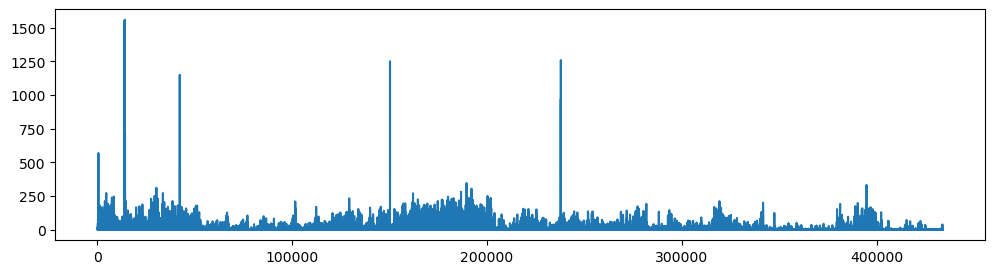

In [181]:
# Now plot speed data
%matplotlib inline
sess.dlc.smooth_pos()
crown_speed = sess.dlc.get_speed(bodypart="crown_middle")
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(crown_speed)

### Finally interpolate all the times to eeg times

In [198]:
sync_sec = (sess.sync['Datetime'] - sess.sync['Datetime'][0]).dt.total_seconds()
dlc_sec_from_oe_start = (sess.dlc.timestamps["Timestamps"] - sess.sync['Datetime'][0]).dt.total_seconds()
eeg_timestamps = np.interp(dlc_sec_from_oe_start, sync_sec, sess.sync["eeg_time"].values)


In [211]:
good_bool = np.zeros_like(eeg_timestamps, dtype="bool")
for rec in sess.sync["Recording"].unique():
    rec_df = sess.sync[sess.sync["Recording"] == rec]
    bool_temp = (eeg_timestamps >= rec_df.loc[rec_df.Condition == "start", "eeg_time"].values[0]) & (eeg_timestamps <= rec_df.loc[rec_df.Condition == "stop", "eeg_time"].values[0])
    good_bool = good_bool | bool_temp

eeg_timestamps[~good_bool] = np.nan

(1700.0, 1800.0)

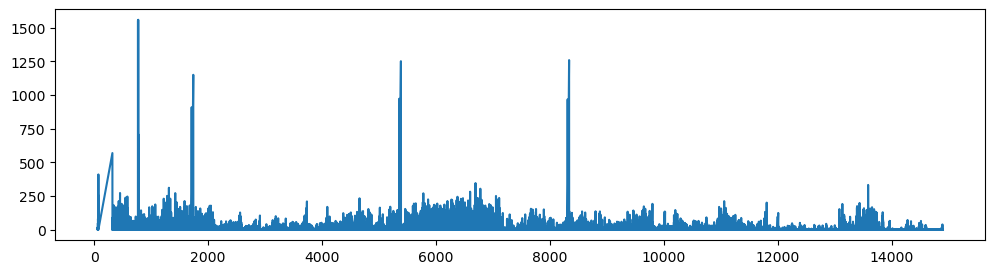

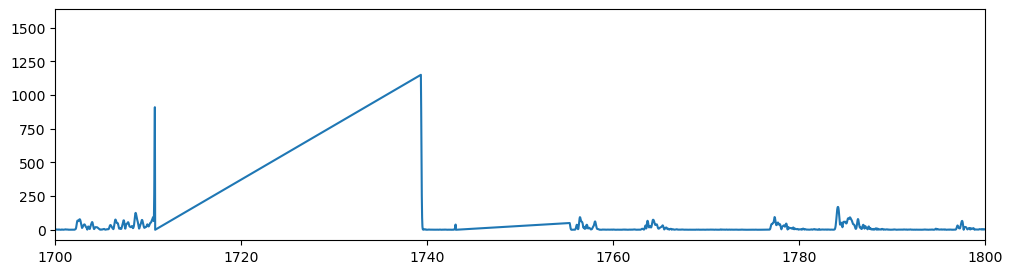

In [217]:
# Now plot again - should see gaps in speed where recording stops that should be ignored
%matplotlib inline
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(eeg_timestamps, crown_speed)

_, ax = plt.subplots(figsize=(12, 3))
ax.plot(eeg_timestamps, crown_speed)
ax.set_xlim((1700, 1800))

# Plan for alignment
designate each recording session in `epochs`, then have an `align_by` flag that will either align by TTL or by timestamps or, in the case of oe and position, align by theta v speed.  Also, for some sessions I have an input from the miniscope to Intan that I can use.

Since some epochs will have a TTL at the start but not later on after a disconnect, you will need to either a) fake a "disconnect" event and only use the TTL if there is an off-on transition after the disconnect, or b) just search for the closet TTL PRIOR to each timestamp to figure out how to align it.  Function would look identify a range of times and then flag them as either "align_by_timestamps" or "align_by_TTL" or "align_by_theta" (position to oe only) or "MS_to_oe_TTL".

# Options for alignment

## 1) TTL - digital or analog?

## 2) Timestamps - currently not accurate enough

## 3) theta as a backup

# Read in DLC pos data and sync with Optitrack timestamps